In [11]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import scipy

# Step 2: Define the path
path = r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\02 Data\Prepared Data'

# Step 3: Load the Data
df_final_dataset = pd.read_pickle(r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\02 Data\Prepared Data\final_dataset.pkl')
departments = pd.read_csv((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\02 Data\Prepared Data\departments_wrangled.csv'), index_col=False)



Step 3: Load Data**
# - Loaded the primary dataset `final_dataset.pkl`.
# - Loaded the departments data `departments_wrangled.csv`.

In [24]:
df_final_dataset.head()


,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,prices,...,order_frequency_flag,Gender,STATE,age,date_joined,n_dependants,fam_status,income,Region,exclusion_flag
21,431534,1,5,4,15,28.0,196,1,1,9.0,...,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423,South,False
22,431534,1,5,4,15,28.0,12427,2,1,4.4,...,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423,South,False
23,431534,1,5,4,15,28.0,10258,3,1,3.0,...,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423,South,False
24,431534,1,5,4,15,28.0,25133,4,1,8.6,...,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423,South,False
25,431534,1,5,4,15,28.0,10326,5,0,2.7,...,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423,South,False


In [26]:
# Step 4: Define and Apply Dependent Flag Function
def get_dependents(n_dependants):
    if n_dependants > 0:
        return 'Has dependents'
    else:
        return 'No dependents'

# Apply the function to create 'dependents_flag' column
df_final_dataset['dependents_flag'] = df_final_dataset['n_dependants'].apply(get_dependents)




In [28]:
# Step 5: Create Customer Profiles
def create_profile(row):
    return f"{row['fam_status']}, {row['dependents_flag']}"

# Apply the function to create a new column 'customer_profile'
df_final_dataset['customer_profile'] = df_final_dataset.apply(create_profile, axis=1)


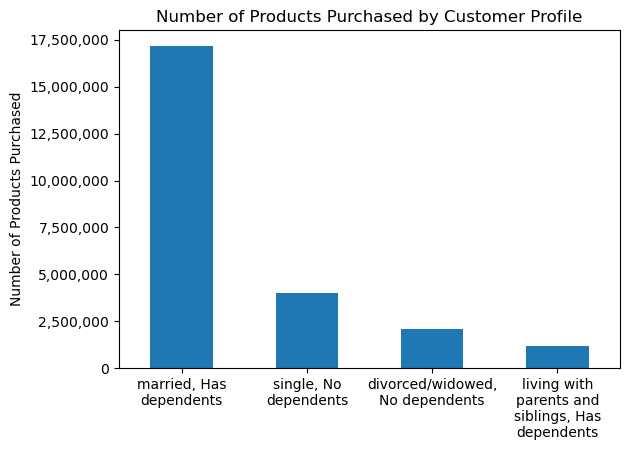

In [36]:
# Step 6: Visualize Customer Profiles
import textwrap

# Create chart showing distribution of customers by 'customer_profile'
counts = df_final_dataset['customer_profile'].value_counts()
ax = counts.plot.bar()

plt.title('Number of Products Purchased by Customer Profile')
plt.xlabel(' ')
plt.ylabel('Number of Products Purchased')

# Format y-axis values
def value_formatter(x, pos):
    return f'{x:,.0f}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(value_formatter))

# Wrap text labels
labels = [textwrap.fill(label, width=17) for label in counts.index]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0, ha='center')

plt.tight_layout()  # Adjust layout to fit labels

# Save the plot
bar_customer_profile = plt.gcf()
bar_customer_profile.savefig((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\04 Analysis\Visualizations\bar_customer_profile.png'), dpi=300, bbox_inches='tight')


In [44]:
# Create 'max_order' by finding the maximum order number for each user
df_final_dataset['max_order'] = df_final_dataset.groupby('user_id')['order_number'].transform('max')

# Group by 'customer_profile' and aggregate 'max_order'
usage_stats = df_final_dataset.groupby('customer_profile').agg({
    'max_order': ['max', 'mean', 'min']
}).reset_index()

# Flatten MultiIndex columns
usage_stats.columns = ['customer_profile', 'Max Order (Max)', 'Max Order (Mean)', 'Max Order (Min)']

# Display the results
print(usage_stats)


                                   customer_profile  Max Order (Max)  \
0                   divorced/widowed, No dependents               99   
1  living with parents and siblings, Has dependents               99   
2                           married, Has dependents               99   
3                             single, No dependents               99   

   Max Order (Mean)  Max Order (Min)  
0         38.775060                5  
1         38.872756                5  
2         38.355520                5  
3         38.791592                5  


In [46]:
# Step 8: Calculate and Aggregate Expenditure Stats
# Group by 'customer_profile' and aggregate 'total_expenditure'
expenditure_stats = df_final_dataset.groupby('customer_profile').agg({
    'total_expenditure': ['max', 'mean', 'min']
}).reset_index()

# Flatten MultiIndex columns
expenditure_stats.columns = ['customer_profile', 'Total Expenditure (Max)', 'Total Expenditure (Mean)', 'Total Expenditure (Min)']

# Display the results
print(expenditure_stats)
expenditure_stats.to_clipboard()


                                   customer_profile  Total Expenditure (Max)  \
0                   divorced/widowed, No dependents                 500263.7   
1  living with parents and siblings, Has dependents                 301074.6   
2                           married, Has dependents                1903700.9   
3                             single, No dependents                1901819.8   

   Total Expenditure (Mean)  Total Expenditure (Min)  
0               4499.276738                      1.1  
1               4284.780873                      1.6  
2               4890.361437                      1.0  
3               4754.241997                      1.0  


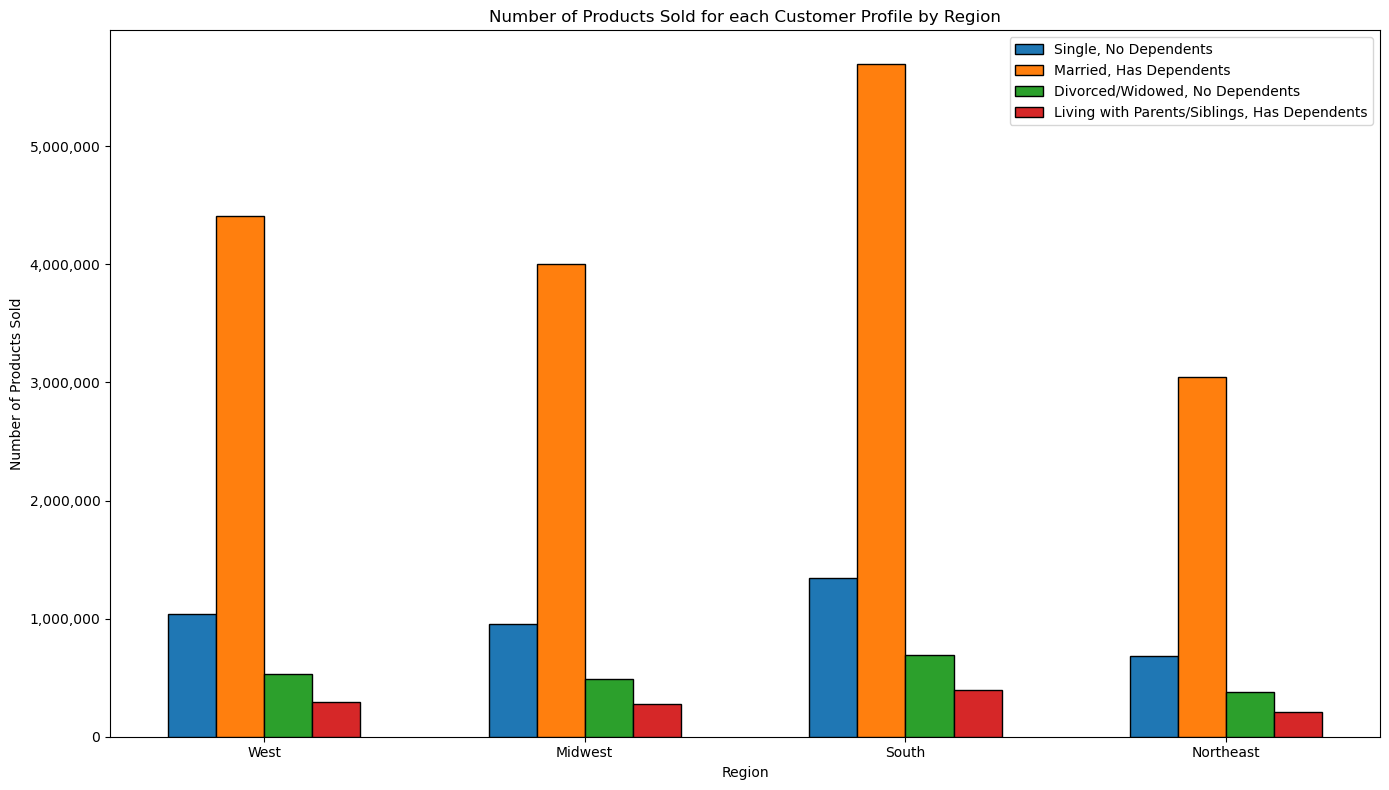

In [54]:
# Step 9: Analyze Customer Profile by Region
# Group by 'region' and 'customer_profile' and count occurrences
customer_profile_counts = df_final_dataset.groupby(['Region', 'customer_profile']).size().unstack(fill_value=0)

# Define the order of regions and customer profiles for consistent plotting
Regions = ['West', 'Midwest', 'South', 'Northeast']
customer_profiles = ['single, No dependents', 'married, Has dependents', 'divorced/widowed, No dependents', 'living with parents and siblings, Has dependents']

# Ensure customer_profile_counts has all regions and customer profiles
customer_profile_counts = customer_profile_counts.reindex(index=Regions, columns=customer_profiles, fill_value=0)

# Plot the results
bar_width = 0.15
r1 = np.arange(len(Regions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(14, 8))

plt.bar(r1, customer_profile_counts['single, No dependents'], width=bar_width, edgecolor='black', label='Single, No Dependents', zorder=3)
plt.bar(r2, customer_profile_counts['married, Has dependents'], width=bar_width, edgecolor='black', label='Married, Has Dependents', zorder=3)
plt.bar(r3, customer_profile_counts['divorced/widowed, No dependents'], width=bar_width, edgecolor='black', label='Divorced/Widowed, No Dependents', zorder=3)
plt.bar(r4, customer_profile_counts['living with parents and siblings, Has dependents'], width=bar_width, edgecolor='black', label='Living with Parents/Siblings, Has Dependents', zorder=3)

plt.xlabel('Region')
plt.ylabel('Number of Products Sold')
plt.title('Number of Products Sold for each Customer Profile by Region')
plt.xticks([r + 1.5 * bar_width for r in range(len(Regions))], Regions)

plt.gca().yaxis.set_major_formatter(FuncFormatter(value_formatter))
plt.legend()
plt.tight_layout()

customer_profile_region = plt.gcf()
customer_profile_region.savefig((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\04 Analysis\Visualizations\customer_profile_region.png'), dpi=300, bbox_inches='tight')


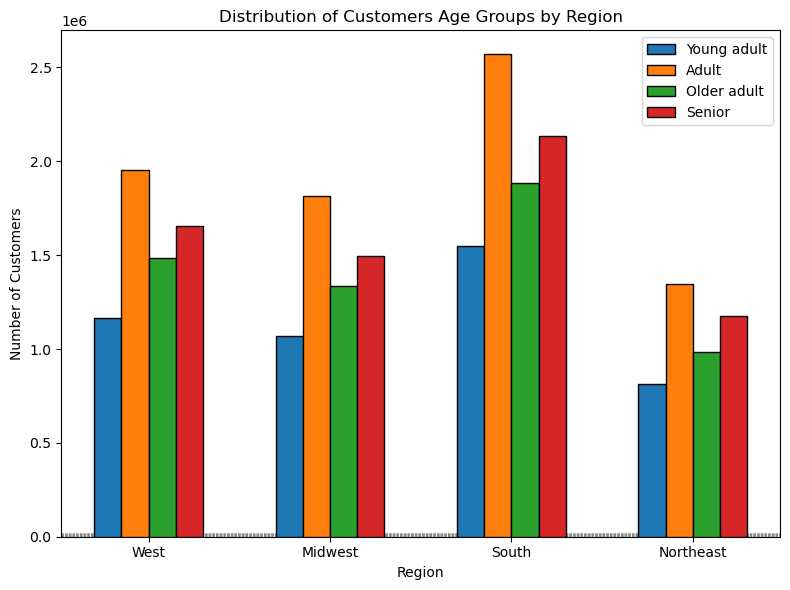

<Figure size 640x480 with 0 Axes>

In [60]:
# Step 10: Analyze Age Group Distribution by Region

# Step 10.1: Create the 'age_group' column based on the 'age' column
def categorize_age(age):
    if age < 30:
        return 'Young adult'
    elif age < 50:
        return 'Adult'
    elif age < 65:
        return 'Older adult'
    else:
        return 'Senior'

# Apply the function to create the 'age_group' column
df_final_dataset['age_group'] = df_final_dataset['age'].apply(categorize_age)

# Step 10.2: Create a DataFrame 'age_group_counts' that contains the counts of each age group for each region.
age_group_counts = df_final_dataset.groupby(['Region', 'age_group']).size().unstack(fill_value=0)

regions = ['West', 'Midwest', 'South', 'Northeast']
age_groups = ['Young adult', 'Adult', 'Older adult', 'Senior']

# Ensure age_group_counts has all regions and age_groups
age_group_counts = age_group_counts.reindex(regions, axis=0).reindex(age_groups, axis=1, fill_value=0)

# Setting the positions and width for the bars
bar_width = 0.15
r1 = np.arange(len(regions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting
plt.figure(figsize=(8, 6))

y_ticks = np.arange(0, 20000, 2500)
for y in y_ticks:
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5, zorder=0)

plt.bar(r1, age_group_counts['Young adult'], width=bar_width, edgecolor='black', label='Young adult', zorder=3)
plt.bar(r2, age_group_counts['Adult'], width=bar_width, edgecolor='black', label='Adult', zorder=3)
plt.bar(r3, age_group_counts['Older adult'], width=bar_width, edgecolor='black', label='Older adult', zorder=3)
plt.bar(r4, age_group_counts['Senior'], width=bar_width, edgecolor='black', label='Senior', zorder=3)

# Adding labels
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers Age Groups by Region')
plt.xticks([r + 1.5 * bar_width for r in range(len(regions))], regions)

plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

# Save the plot
plt.savefig((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\04 Analysis\Visualizations\age_groups_by_region.png'), dpi=300, bbox_inches='tight')


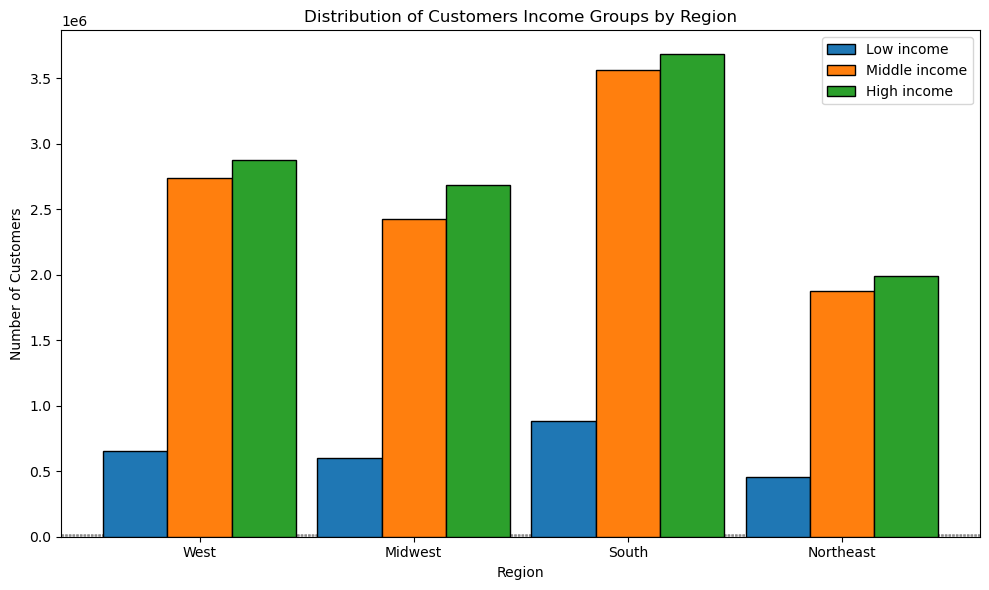

In [66]:
# Step 11.1: Create the 'income_group' column based on the 'income' column
def categorize_income(income):
    if income < 50000:
        return 'Low income'
    elif income < 100000:
        return 'Middle income'
    else:
        return 'High income'

# Apply the function to create the 'income_group' column
df_final_dataset['income_group'] = df_final_dataset['income'].apply(categorize_income)

# Step 11.2: Create a DataFrame 'income_group_counts' that contains the counts of each income group for each region.
income_group_counts = df_final_dataset.groupby(['Region', 'income_group']).size().unstack(fill_value=0)

Regions = ['West', 'Midwest', 'South', 'Northeast']
income_groups = ['Low income', 'Middle income', 'High income']

# Ensure income_group_counts has all regions and income_groups
income_group_counts = income_group_counts.reindex(Regions, axis=0).reindex(income_groups, axis=1, fill_value=0)

# Setting the positions and width for the bars
bar_width = 0.3
r1 = np.arange(len(Regions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting
plt.figure(figsize=(10, 6))

y_ticks = np.arange(0, 25000, 5000)
for y in y_ticks:
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5, zorder=0)
    
plt.bar(r1, income_group_counts['Low income'], width=bar_width, edgecolor='black', label='Low income', zorder=3)
plt.bar(r2, income_group_counts['Middle income'], width=bar_width, edgecolor='black', label='Middle income', zorder=3)
plt.bar(r3, income_group_counts['High income'], width=bar_width, edgecolor='black', label='High income', zorder=3)

# Adding labels
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers Income Groups by Region')
plt.xticks([r + bar_width for r in range(len(Regions))], Regions)

plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\04 Analysis\Visualizations\income_groups_by_region.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


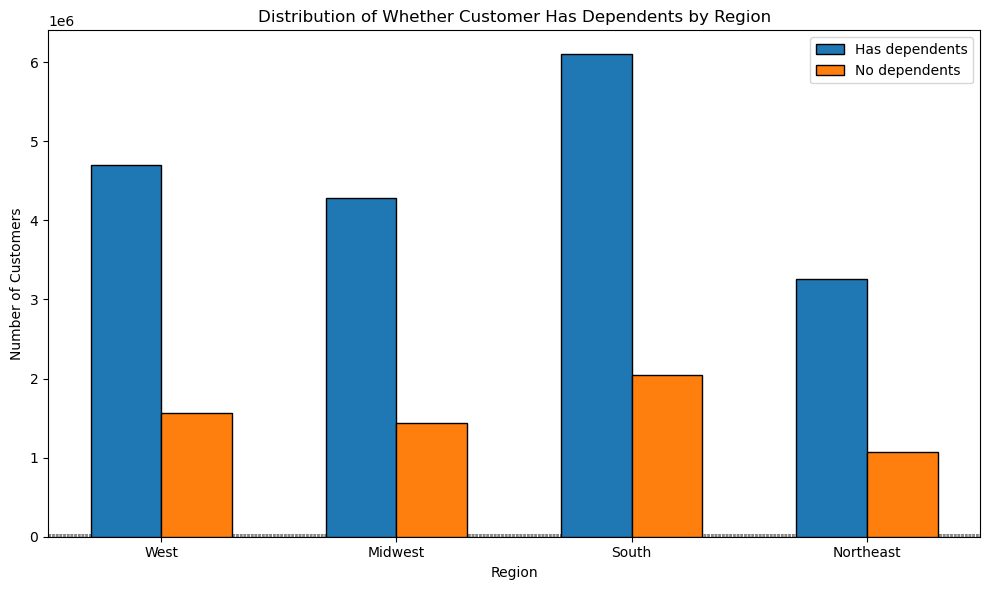

In [70]:
# Step 12: Analyze Dependents Group Distribution by Region
# Create a DataFrame dependents_group_counts that contains the counts of each dependents group for each region.
dependents_group_counts = df_final_dataset.groupby(['Region', 'dependents_flag']).size().unstack(fill_value=0)

Regions = ['West', 'Midwest', 'South', 'Northeast']
dependents_groups = ['Has dependents', 'No dependents']

# Ensure dependents_group_counts has all regions and dependents_groups
dependents_group_counts = dependents_group_counts.reindex(Regions, axis=0).reindex(dependents_groups, axis=1, fill_value=0)

# Setting the positions and width for the bars
bar_width = 0.3
r1 = np.arange(len(Regions))
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(10, 6))

y_ticks = np.arange(0, 45000, 5000)
for y in y_ticks:
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5, zorder=0)

plt.bar(r1, dependents_group_counts['Has dependents'], width=bar_width, edgecolor='black', label='Has dependents', zorder=3)
plt.bar(r2, dependents_group_counts['No dependents'], width=bar_width, edgecolor='black', label='No dependents', zorder=3)

# Adding labels
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.title('Distribution of Whether Customer Has Dependents by Region')
plt.xticks([r + bar_width / 2 for r in range(len(Regions))], Regions)

plt.legend(loc='upper right')
plt.tight_layout()

# Save the plot
plt.savefig((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\04 Analysis\Visualizations\dependents_by_region.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [76]:
print(top_10_departments.columns)
print(departments.columns)


Index(['department_id', 'number_of_products_sold'], dtype='object')
Index(['department'], dtype='object')


In [92]:
# Count the number of products sold for each department
department_sales = df_final_dataset.groupby('department_id')['product_id'].count()

# Sort the departments by the number of products sold in descending order
department_sales_sorted = department_sales.sort_values(ascending = False)

# Limit to the top 10 departments
top_10_departments = department_sales_sorted.head(10)

In [96]:
top_10_departments

department_id
4.0     7227091
16.0    4132458
19.0    2187121
7.0     2036472
1.0     1628844
13.0    1385520
3.0      886698
15.0     787790
20.0     783011
9.0      633725
Name: product_id, dtype: int64

In [126]:
departments['department_id'] = range(1, len(departments) + 1)  


In [128]:
top_10_departments.rename(columns = {'product_id' : 'number_of_products_sold'}, inplace = True)

In [130]:
top_10_departments

,department_id,number_of_products_sold
0,4.0,7227091
1,16.0,4132458
2,19.0,2187121
3,7.0,2036472
4,1.0,1628844
5,13.0,1385520
6,3.0,886698
7,15.0,787790
8,20.0,783011
9,9.0,633725


In [132]:
departments.rename(columns={'Unnamed: 0' : 'department_id'}, inplace=True)

In [134]:
departments

,department,department_id
0,frozen,1
1,other,2
2,bakery,3
3,produce,4
4,alcohol,5
5,international,6
6,beverages,7
7,pets,8
8,dry goods pasta,9
9,bulk,10


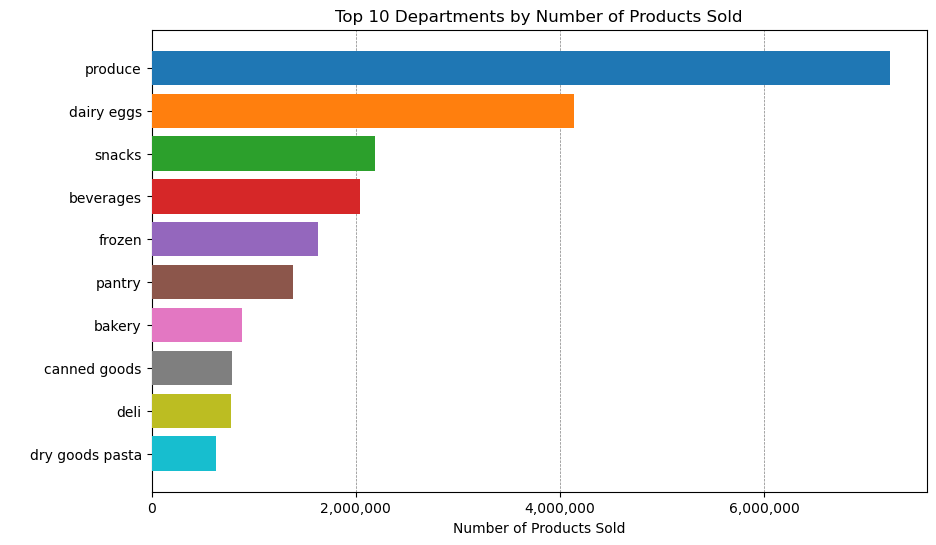

In [136]:
# Merge with top_10_departments
top_10_departments_merged = top_10_departments.merge(departments, on='department_id', how='left')

# Create horizontal bar chart showing the top 10 departments by number of products sold
plt.figure(figsize=(10, 6))

plt.title('Top 10 Departments by Number of Products Sold')

# Set x-ticks and add vertical grid lines
x_ticks = np.arange(0, 10000000, 2000000)
plt.xticks(x_ticks)
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='grey', zorder=0)

# Define a function to format x-axis labels
def value_formatter(x, pos):
    return f'{x:,.0f}'
plt.xlabel('Number of Products Sold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(value_formatter))

plt.ylabel(' ')

plt.gca().invert_yaxis()  # Invert y-axis to have the department with the highest sales on top

# Plot chart
colors = plt.get_cmap('tab10')  # 'Set1' is a color map available in matplotlib
plt.barh(top_10_departments_merged['department'], top_10_departments_merged['number_of_products_sold'], color=colors(range(10)), zorder=3)

top_departments = plt.gcf()

# Save the plot
save_path = os.path.join('C:\\Users\\sudee\\OneDrive\\Documents\\Python Scripts\\Instacart Basket Analysis\\04 Analysis\\Visualizations')
os.makedirs(save_path, exist_ok=True)
top_departments.savefig(os.path.join(save_path, 'top_departments.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [144]:
# Step 14: Export the Final Data
# Save the final dataset to a pickle file
df_final_dataset.to_pickle((r'C:\Users\sudee\OneDrive\Documents\Python Scripts\Instacart Basket Analysis\02 Data\Prepared Data\final_dataset 2.pkl'))
